## Part 0: Preliminaries

### Part 0.1: imports & constants

In [1]:
#for cleaner output in notebook, of course won't be triggered in the library
import warnings
warnings.filterwarnings('ignore')

from warnings import warn

#library dependencies (used to compute PCVs and for the DFT)
import numpy as np
import music21 as m21
import pretty_midi as pm

#drawing dependencies.
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from matplotlib.ticker import MultipleLocator, IndexLocator,FuncFormatter
from madmom.audio import chroma


#all part of the python standard library
import tempfile
import math
import os

test_midi_folder = 'midiFiles/'
test_xml_folder = 'xmlFiles/'
test_audio_folder = 'audioFiles/'

bach_prelude_midi = test_midi_folder + '210606-Prelude_No._1_BWV_846_in_C_Major.mid'
bach_prelude_hc_audio = test_audio_folder + 'bach_prelude_hapsichord.ogg'

giant_steps_midi = test_midi_folder + 'giant_steps_first_chorus.mid'
giant_steps_audio = test_audio_folder + 'giant_steps_first_chorus.wav'

fs_midi = test_midi_folder + 'Faust_Symphony_mov1.mid'
fs_audio = test_audio_folder + 'faust_symphony_intro.aifc'

chopin_midi = test_midi_folder + 'chopin-prelude-op28-2.mid'
chopin_audio = test_audio_folder + 'chopin_krissin.wav'

### Part 0.2: Test functions

In [2]:
def test(assertion, test_name, test_logger):
    test_logger[test_name] = assertion

def test_bilan(test_logger):
    all_good = True
    failed_tests = [k for k,v in test_logger.items() if not v]
    test_nmbr = len(test_logger.items())
    if len(failed_tests) > 0:
        print("%d out of %d tests failed. The failed tests are: "%(len(failed_tests), test_nmbr))
        for s in failed_tests:
            print('-'+s)
    else:
        print("All %d tests succeeded."%test_nmbr)

# Part 1: file to list of PCVs 

## Part 1.1 code

In [32]:
twelve_tones_vector_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#','A', 'A#', 'B']

#this is to correct the name found in the outputed notes from music21 parsing of symbolic data files.
#Since this library assumes enharmonic equivalence, any note's name should be mapped to one of the twelve values
#found in 'twelve_tones_vector_name'
altered_notation_dict = {
    'C-' : 'B',
    'C--': 'A#',
    'C---': 'A',
    'C##' : 'D',
    'C###' : 'D#',
    'D-' : 'C#',
    'D--' : 'C',
    'D---' : 'B',
    'D##' : 'E',
    'D###' : 'F',
    'E-' : 'D#',
    'E--' : 'D',
    'E---' : 'C#',
    'E#' : 'F',
    'E##' : 'F#',
    'E###' : 'G',
    'F-' : 'E',
    'F--' : 'D#',
    'F---' : 'D',
    'F##' : 'G',
    'F###' : 'G#',
    'G-' : 'F#',
    'G--' : 'F',
    'G---' : 'E#',
    'G##' : 'A',
    'G###' : 'A#',
    'A-' : 'G#',
    'A--' : 'G',
    'A---' : 'F#',
    'A##': 'B',
    'A###': 'C',
    'B-' : 'A#',
    'B--' : 'A',
    'B---' : 'G#',
    'B#' : 'C',
    'B##': 'C#',
    'B###': 'D',
} 

pitch_pitch_dict = {x: x for x in twelve_tones_vector_name}

#In the end we want each string to match an index between 0 and 11, so it fits inside a 12-d vector.
pitch_index_dict = {twelve_tones_vector_name[i]:i for i in range(len(twelve_tones_vector_name))}

#So any pitch name given to this dict will be mapped to its cannonical form defined in 'twelve_tones_vector_name'
normalize_notation_dict = dict(altered_notation_dict,  **pitch_pitch_dict)

def recursively_map_offset(filepath, only_note_name=True):
    '''
    This function recursively walks through the file's  stream's elements, 
    and whenever it encounters a note, it will append its rhytmic 
    data to the pitch and then store the resulting data structure in an array.
    If a music21 element of type chord is encountered, the chord is decomposed into all
    notes it is composed by, and each of thoses notes are appended the 
    Returns the aforementionned array.
    The rhytmic data is expressed as a tuple of the offset of the beginning of the note
    and the offset of the end of the note.
    
    All temporal informations from MIDI events parsed by the music21 library are encoded
    as unit of quarter notes count, regardless of the BPM+ or the time signature.
    
    Parameters
    ----------
    filepath : str
        the path of the MIDI file to be parsed into the list of pitches and time offset.
        
    only_note_name: bool, optional 
        indicates whether the notes need to be converted from music21 object with octave indication
        to only a string indicating the pitch class name. 
        Default value is True.
        
    Returns
    -------
    iterable of tuples
        the first element of each tuple from this iterable can either be a string indicating the 
        pitch class name of an occurence of one note, or an instance of music21.note representing 
        the occurence of one note, if the parameters 'only_note_name' is set to 'False'. 
        The second half of the tuple, is a tuple itself of float values, the first indicating
        the start offset in time of the note's occurrence, while the second indicates the end
        offset in time of the note's occurrence. Both values are expressed in terms of quarter 
        note length.
        '('E', (10,11,5))' for example would be one element of this iterable, representing an E note
        which starts at the 10th quarter note of the MIDI file and stops one quarter note and half
        later in the piece. 
        
    
    '''
    midi_stream = m21.converter.parse(filepath)
    res = []
    for elem in midi_stream.recurse():
        if isinstance(elem, m21.note.Note):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res.append((elem.name if only_note_name else elem, (start_offset, start_offset+elem.duration.quarterLength)))
        elif isinstance(elem, m21.chord.Chord):
            start_offset = elem.getOffsetInHierarchy(midi_stream)
            res += list(map(lambda r: (r.name if only_note_name else r , (start_offset, start_offset+elem.duration.quarterLength)), elem.pitches))
    return res


def remove_drums_from_midi_file(midi_filepath):
    '''
    Takes care of removing drum tracks from a midi filename.
    Work only if the MIDI file has metadata clearly indicating channels that are
    percussive. Does not remove channels of percussive instruments that are pitched
    (like the glockenspiel or the xylophone for instance).  
    
    Parameters
    ----------
    midi_filepath : str  
        the file path of the MIDI file that needs to have percussive channels removed. 
    
    Returns
    -------
    str
        A file path of the same midi file generated without the percussive channels.
        This file path leads to a temporary folder generated on the user's OS file system
        The existence of such temporary folder can not be guaranteed to last for a long
        span of time, this depends on the user's OS bahvior fir temporary folder. As such,
        the resulting file should be used as soone as possible, or moved to a permanet folder.
    
    '''
    sound = pm.PrettyMIDI(midi_filepath)
    
    #getting the track indices of unpitched "percussive" tracks. 
    drum_instruments_index = [idx for idx, instrument in enumerate(sound.instruments) if instrument.is_drum]
    for i in sorted(drum_instruments_index, reverse=True):
        del sound.instruments[i]

    folder = tempfile.TemporaryDirectory()
    temp_midi_filepath = folder.name+'tmp.mid'
    sound.write(temp_midi_filepath)
    
    return temp_midi_filepath

def slice_according_to_beat(pitch_offset_list, beat1_offset, beat2_offset):
    '''
    the beat offset must be expressed as units of quarter notes. 
    Taken are all beat which at least END AFTER the beat1, and START BEFORE the beat2
    '''
    def only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset): 
        return list(filter(lambda n: n[1][1] >= beat1_offset and n[1][0] <= beat2_offset, pitch_offset_list))

    res = []
    if beat1_offset >= beat2_offset:
        return res
    for n in only_keep_pitches_in_boundaries(pitch_offset_list, beat1_offset, beat2_offset):
        start_b = n[1][0]
        end_b = n[1][1]
        
        res_n = None
        if start_b >= beat1_offset:
            if end_b > beat2_offset:
                res_n = (n[0], (start_b, beat2_offset))
            else:
                res_n = (n[0], (start_b, end_b))
        elif end_b <= beat2_offset:
            #if start_b < beat1_offset: #of course we are in this case since the first if was not triggered.
            res_n = (n[0], (beat1_offset, end_b))
        else:
            #we are thus in the case the start and end time of the note overshoot the boundaries.
            res_n = (n[0], (beat1_offset, beat2_offset))
        #normally inconsistent results should not happen, but it is possible to have a note with duration equals to 0. This line below prevents that and thus keep the things concise.
        if res_n[1][0] < res_n[1][1]:
            res.append(res_n)
    return res

def sum_into_pitch_class_vector(pitch_offset_list, start_beat, end_beat):
    pitch_class_offset = lambda t: pitch_index_dict[normalize_notation_dict[t[0]]]
    pitch_class_vec = np.zeros(12)
    for tup in pitch_offset_list:
        #we need to be sure we don't take into account the part of the note that exceed the window's size.
        min_beat = max(start_beat, tup[1][0])
        max_beat = min(end_beat, tup[1][1])
        pitch_weight = max_beat - min_beat
        pitch_class_vec[pitch_class_offset(tup)] += pitch_weight
    return pitch_class_vec


def get_max_beat(pitch_offset_list):
    return math.ceil(max(list(map(lambda r: r[1][1], pitch_offset_list))))

def pitch_class_set_vector_from_pitch_offset_list(pitch_offset_array, aw_size=0.5): #the analysis window size (aw_size) is expressed in terms of number of beat (quarter of measures in binary time signature).
    '''
    This functions transforms a list of tuples each containing the name of the pitch
    followed by its start and end in the file into a pitch class distribution with each
    pitch class given the weight corresponding to its duration in the current slice of
    temporal size aw_size.
    
    '''
    max_beat = get_max_beat(pitch_offset_array)
    
    if aw_size <= max_beat/2:
        chunk_number = math.ceil(max_beat/aw_size)
    else:
        raise Exception('The analysis window\'s size (%lf) should not exceed half the duration of the musical piece (%lf).'%(aw_size, max_beat/2.))
    
    res_vector = np.full((chunk_number, 12), 0.0, np.float64)

    for b in range(chunk_number):
        start_beat = b*aw_size
        stop_beat = (b+1)*aw_size
        analysis_windows = slice_according_to_beat(pitch_offset_array, start_beat, stop_beat)
        pitch_class_vec = sum_into_pitch_class_vector(analysis_windows, start_beat, stop_beat)
        res_vector[b] = pitch_class_vec
    
    return res_vector

#useful to increase the default resolution 
def reframe_pc_mat(pc_mat, bin_size):
    if bin_size == 1:
        return pc_mat
    
    curr_bin_nb = pc_mat.shape[0]
    new_bin_nb = int(math.ceil(curr_bin_nb/bin_size))
    res = np.full((new_bin_nb, pc_mat.shape[1]), 0., np.float64)
    for i in range(new_bin_nb):
        res[i] = sum(pc_mat[int(i*bin_size):int((i+1)*bin_size)])
    return res

#left here for comparison purpose.
def librosa_chromagram(filepath, aw_size):
    audio_array, sample_ratio = librosa.load(filepath)
    
    hop_len = round(sample_ratio*aw_size) #hop_len is the analysis window size for the chromagrams in terms of number of sample.
    #so the result's shape is consistent with the one produced in the case of midi files.
    return np.transpose(librosa.feature.chroma_stft(audio_array, sample_ratio, hop_length=hop_len))


deep_chroma_processor = chroma.DeepChromaProcessor()

def madmom_chromagram(filepath, aw_size, deep_chroma = False):
    dcp_base_fps = 10
    fps = 1./float(aw_size)
    if aw_size < .1:
        raise Exception("Audio PCV extraction using the deep chroma extractor can not be done for resolution lower than 0.1 (one tenth of a second)")
    
    if deep_chroma:
        chromagrams = deep_chroma_processor.process(filepath)
        return reframe_pc_mat(chromagrams, (dcp_base_fps/fps)) 
    else:
        clp = chroma.CLPChromaProcessor(fps=fps)
        return clp.process(filepath)
    
# trim the input array so that no empty vectors are located at the beginning and end of the muscial piece
def trim_pcs_array(pcvs):
    start = 0
    while not np.any(pcvs[start]):
        start += 1
    end = len(pcvs) - 1
    while not np.any(pcvs[end]):
        end -= 1
    return pcvs[start:end+1]

def produce_pitch_class_matrix_from_filename(filepath, aw_size = 1., trim_extremities=True, remove_percussions = False, deep_chroma = False):
    '''
    This function takes a MIDI or XML file as a parameters and
    transforms it into "list of pitch class distribution"
    This list is modelised by a Nx12 matrix of float values, each 
    row of the matrix corresponds to the pitch content of one slice
    of temporal size "aw_size" from the musical content from the
    input's file. The number of row N depends on the temporal size
    of the file, and the number chosen for aw_size.
    
    Parameters
    ----------
    filepath : str 
        the path of the MID/MIDI/XML/MUSICXML/WAV file whose musical content 
        is transformed into the pitch class distribution's list.
        It should be noted that MIDI file exported by Musescore often features 
        "truncated" note's length for the playback to feel more natural, however this 
        affects the the Pitch Class Vectors produced from this function. For example,
        notes shorter than a sixteenth notes will simply be mapped to a weight of 0 in
        the resulting PCVs. If you use MuseScore to edit scores, always export your musical
        pieces in xml format, as this format does not suffer from those truncations. Only
        use MIDI if you are certain of the integrity of your file, or if you don't have any choices.
        Other audio file formats than WAV are supported, but they all rely on "ffmpeg" and as
        such are only supported if this package is installed.
        
    aw_size : float, optional
        means "analysis window's size", represent the size of each
        slice of pitch content from the file in terms of time. In the case 
        of MIDI file, this number represent the number of beat (a beat being
        a quarter note), and in the case of WAV file, this number represents 
        the number of seconds.
        Default value is 1 (1 quarter note, or 1 second depending on the file's type)
                
    trim_extremities : bool, optional
        inidicates whether the silences that are present at both
        extremities of the musical piece needs to be removed from the resulting list of pitch
        class distribution. Only apply to input data in symbolic format (i.e. not on real audio)
        Default value is True.
                 
    remove_percussions : bool, optional 
        indicates whether percussive instruments need to be removed from the mix. 
        ONLY APPLIES TO MIDI FILES CURRENTLY.
        Default value is False.
        
    deep_chroma: bool, optional
        indicates which chromagram extractor to use from the madmom library.
        If set to True, the DeepChromaProcessor (a pretrained DNN with a set resolution
        of one tenth of a second) is used, otherwise, the CLPChromaProcessor 
        (a method of PCV retrival using log-compression with parametric resolution) 
        from madmom is used.
        Default value is False. 
    
    Returns
    -------
    numpy matrix of shape Nx12 (numpy.ndarray of numpy.float64)
        This matrix holds the pitch distributions corresponding to all
        the pitch content from all non overlapping slices of aw_size size from the file
        given as argument.
    
    '''
    lower_filepath = filepath.lower()
    midi_extensions = ('.mid', '.midi')
    xml_extensions = ('.mxl', '.xml', '.musicxml')

    if not os.path.isfile(filepath):
        raise Exception('Cannot find file "%s"'%filepath)
    
    if lower_filepath.endswith(midi_extensions) or lower_filepath.endswith(xml_extensions):
        
        if deep_chroma:
            warn("argument 'deep_chroma' is meaningless on Symbolic data input. Only use it for real audio data.")
        
        #percussion filtering only for midi files for now.
        if lower_filepath.endswith(midi_extensions) and remove_percussions:
            filepath = remove_drums_from_midi_file(filepath)
        elif remove_percussions:
            warn("argument 'remove_percussions' currently only work on MIDI data.")
        
        pitch_offset_list = recursively_map_offset(filepath)
        pcvs_arr = pitch_class_set_vector_from_pitch_offset_list(pitch_offset_list, aw_size)
    else:
        #audio file input.
        if remove_percussions:
            warn("'remove_percussions' argument is meaningless on real audio. Only use it for MIDI.")
        pcvs_arr = madmom_chromagram(filepath, aw_size, deep_chroma)
        
    return trim_pcs_array(pcvs_arr) if trim_extremities else pcvs_arr

## Part 1.2 tests

In [48]:
test_logger = {}

EIGHT_NOTE_AW_SIZE = 0.5
QUARTER_NOTE_AW_SIZE = 1

if os.path.exists(bach_prelude_midi):

    #### MAX BEAT TEST
    BACH_PRELUDE_MAX_BEAT = 35 * 4
    bp_po_list = recursively_map_offset(bach_prelude_midi)
    test(BACH_PRELUDE_MAX_BEAT == get_max_beat(bp_po_list), \
         'Bach\'s Prelude has the right value for the max beat'\
         ,test_logger)

    #### DEFAULT AW SIZE TEST
    bp_pcm = produce_pitch_class_matrix_from_filename(bach_prelude_midi)
    test(np.shape(bp_pcm)[0] == BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with default analysis window has \
         the right amount of beats', test_logger)

    #### AW SIZE = 1 TEST
    bp_pcm_aw1 = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=1)
    test(np.shape(bp_pcm_aw1)[0] == BACH_PRELUDE_MAX_BEAT, \
         'Bach\'s Prelude parsed with unit analysis window has \
         the right amount of beats', test_logger)

    #### AW_SIZE = MAX_BEAT/2 
    bp_pcm_aw_half = produce_pitch_class_matrix_from_filename(bach_prelude_midi, aw_size=BACH_PRELUDE_MAX_BEAT/2)
    test(np.shape(bp_pcm_aw_half)[0] == 2, \
         'Bach\'s Prelude parsed with analysis window  of half the length of \
         the musical piece has the right amount of beats', test_logger)
else:
    test(False, 'No midi file exists for Bach\'s  Prelude in C Major (BWV 846)', test_logger)

    
    #### MIDI transcription of dummy musical piece with rest in the middle.
    ### This file is basically all quarter notes of the following pitch classes in sequences:
    ### E - G  - G - B - [full measure rest] - F - C - A - E

empty_space_midi = test_midi_folder + 'emptyspace.mid'
if os.path.exists(empty_space_midi):
    #### CONVERSION OF RESTS INTO EMPTY VECTOR
    e_mat = produce_pitch_class_matrix_from_filename(empty_space_midi, aw_size=1)
    are_empties_empty = not np.any(e_mat[4]) and not np.any(e_mat[5]) and  not np.any(e_mat[6]) and  not np.any(e_mat[7])
    test(are_empties_empty,\
         'dummy file with rests has rests parsed as null vectors',
        test_logger)
    are_notempties_not_empty = np.any(e_mat[3]) and np.any(e_mat[8])
    test(are_notempties_not_empty,\
         'dummy file with rests has notes parsed as non empty vectors',
        test_logger)
else:
    test(False, 'No midi file exists to test empty spaces in measures', test_logger)

    
### This midi file holds a treble clef track, a drumset track, a triangle, 
### a hand clap and a tambourine track, as well as a xylophone track. Except the soprano and the xylophone,
### all tracks are considered percussive and not holding relevant pitch information. 
percussive_midi = test_midi_folder + 'NCandP.mid'
if os.path.exists(percussive_midi):

    #### REMOVING DRUM TRACKS FROM A MIDI FILE WITH 4 UNPITCHED PERCUSSIVE TRACKS TEST.
    count_midi_tracks = lambda fn: len(list(pm.PrettyMIDI(fn).instruments))
    ALL_TRACKS_NUMBER = 6
    PERCU_TRACKS_NUMBER = 4
    assert(count_midi_tracks(percussive_midi) == ALL_TRACKS_NUMBER)
    drumless_fn = remove_drums_from_midi_file(percussive_midi)
    
    test(count_midi_tracks(drumless_fn) == (ALL_TRACKS_NUMBER - PERCU_TRACKS_NUMBER),\
         'File with 4 drum tracks out of 6 got those tracks removed by function "remove_drums_from_midi_file"',
        test_logger)
else:
    test(False, 'No midi file exists to test the removal of percussive instruments', test_logger)

### Dummy midi track with few notes, and two empty measures at the beginning of the file. 
### this midi file describes a musical piece with 2 measures of rest at the beginning. 
### Produced to test the trim option from the midi to pcv matrix conversion's function.
trim_midi = test_midi_folder + 'trim_extremities_test.mid'
if os.path.exists(trim_midi):
    #### 'trim_extremities = True' DO TRIM THE EXTREMETIES.
    MEASURE_AW_SIZE = 4
    number_with_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, aw_size=MEASURE_AW_SIZE))[0]
    number_without_trim = np.shape(produce_pitch_class_matrix_from_filename(trim_midi, trim_extremities=False, aw_size=MEASURE_AW_SIZE))[0]
    test(number_with_trim == (number_without_trim - 2),\
         'File with 2 measures of rest at the beginning is trimmed by option "trim_extremities" from function "produce_pitch_class_matrix_from_filename"',
        test_logger)
else:
    test(False, 'No midi file exists to test the trim of empty measure at the beginnning and end of file', test_logger)

### XML files holding 4 bars, each containing of eight notes spanning all diatonic tones present 
### in an octave from C to C (included). The first bar has double flat on all tones, the second
### has double sharps on all tones, the third triple flat on all tones, and the last, triple sharps
### on all tones.
test_extreme_accidentals_xml = test_xml_folder + 'ExtremeAccidentals.musicxml'
if os.path.exists(test_extreme_accidentals_xml):
    pcvs = produce_pitch_class_matrix_from_filename(test_extreme_accidentals_xml, aw_size = EIGHT_NOTE_AW_SIZE)
    #not including the last notes as it is the same as the first one.
    bar_double_flat = pcvs[0:7]
    bar_double_sharp = pcvs[8:15]
    
    #triple accidentals are not working with xml exports.
    #bar_triple_flat = pcvs[16:23]
    #bar_triple_sharp = pcvs[24:31]
    bars = [bar_double_flat, bar_double_sharp]#, bar_triple_flat, bar_triple_sharp]
    hw_CM = [.5,0,.5,0,.5,.5,0,.5,0,.5,0,.5]
    #direction to roll the reference C major diatonic scale, in the order double flat, double sharp, triple flat and triple sharp
    roll_direction = [-2,2,-3,3]
    for i in range(len(bars)):
        hw_CM_accidentals = np.roll(hw_CM, roll_direction[i])
        test( (hw_CM_accidentals == sum(bars[i])).all(), \
             'Accidentals of %d semitones not correctly parsed by produce_pitch_class_matrix_from_filename'%roll_direction[i], test_logger)
    
else:
    test(False, 'No xml file exists to test the correct mapping of double/triple sharp/flats in xml files', test_logger)

#test if non existing file exception gets launched as expected
unexisting_file = 'qwertzuiopasdfghjklyxcv.bmn'
existence_test_bool = False
try:
    produce_pitch_class_matrix_from_filename(unexisting_file)
except Exception:
    existence_test_bool = True
test(existence_test_bool, "A non existing file was registered as existing.", test_logger)


## Test reframe function (that is used for resolution correction on the DeepChromaProcessor)
C = [1,0,0,0,0,0,0,0,0,0,0,0]
D = [0,0,1,0,0,0,0,0,0,0,0,0]
E = [0,0,0,0,1,0,0,0,0,0,0,0]
F = [0,0,0,0,0,1,0,0,0,0,0,0]
G = [0,0,0,0,0,0,0,1,0,0,0,0]
A = [0,0,0,0,0,0,0,0,0,1,0,0]

hexachord = np.array([C, D, E, F, G, A])

def vect_add(vec1, vec2):
    return list(map(sum, zip(vec1,vec2)))

cd, ef, ga = reframe_pc_mat(hexachord, 2)
cde, fga = reframe_pc_mat(hexachord, 3)
cdef, ga = reframe_pc_mat(hexachord, 4)
test((cd == vect_add(C,D)).all(), 'reframe_pc_mat with bin size 2 does not work', test_logger)
test((ef == vect_add(E,F)).all(), 'reframe_pc_mat with bin size 2 does not work', test_logger)
test((ga == vect_add(G,A)).all(), 'reframe_pc_mat with bin size 2 does not work', test_logger)
test((cde == vect_add(vect_add(C,D),E)).all(), 'reframe_pc_mat with bin size 3 does not work', test_logger)
test((fga == vect_add(vect_add(F,G),A)).all(), 'reframe_pc_mat with bin size 3 does not work', test_logger)
test((ga == vect_add(G, A)).all(), 'reframe_pc_mat with bin size 4 does not work', test_logger)
test((cdef == vect_add(vect_add(C,D),vect_add(E,F))).all(), 'reframe_pc_mat with bin size 4 does not work', test_logger)
test((ga == vect_add(G, A)).all(), 'reframe_pc_mat with bin size 4 does not work', test_logger)
    
test_bilan(test_logger)

All 14 tests succeeded.


## Part 2: Apply DFT and Generate UTM

### Part 2.1 code

In [5]:
def build_utm_from_one_row(res):
    '''
    given a NxN matrix whose first row is the only
    one that's filled with values, this function fills
    all the above row by summing for each row's element
    the two closest element from the row below. This
    method of summing builds an upper-triangle-matrix
    whose structure represent all hierarchical level.
    '''
    pcv_nmb = np.shape(res)[0]
    for i in range(1, pcv_nmb):
        for j in range(0, pcv_nmb-i):
            res[i][i+j] = res[0][i+j] + res[i-1][i+j-1]
    return res

def apply_dft_to_pitch_class_matrix(pc_mat, build_utm = True):
    '''
    This functions takes a list of N pitch class distributions,
    modelised by a matrix of float numbers, and apply the 
    DFT individually to all the pitch class distributions.
    
    Parameters
    ----------
    pc_mat: numpy matrix of shape (N, 12) (numpy.ndarray of numpy.float64)
        holds the pitch class distribution of all slice of a minimum temporal size.
    build_utm: bool, optional 
        indicates whether the resulting list of DFT results need to be built into an upper 
        triangle matrix representing all hierarchical levels possible from the original musical piece.
        As the DFT is linear, the computation of all hierarchical levels can be done at a later sate,
        thus saving some space (O(n) instead of O(n^2)).
        Default value is True.
    
    Returns
    -------
    numpy matrix (numpy.ndarray of numpy.complex128)
        according to the parameters 'build_utm', either a Nx7 complex number matrix being
        the converted input matrix of pitch class distribution
        transformed into Fourier coefficient, or a NxNx7 complex number 
        upper triangle matrix being the fourier coefficient obtained from all
        possible slices of the original musical piece.
    '''
    pcv_nmb, pc_nmb = np.shape(pc_mat)
    #+1 to hold room for the 0th coefficient
    coeff_nmb = int(pc_nmb/2)+1
    res_dimensions = (pcv_nmb, coeff_nmb)
    res = np.full(res_dimensions, (0. + 0.j), np.complex128)

    for i in range(pcv_nmb):
        res[i] = np.fft.fft(pc_mat[i])[:coeff_nmb] #coeff 7 to 11 are uninteresting (conjugates of coeff 6 to 1).
    
    if build_utm:
        new_res = np.full((pcv_nmb, pcv_nmb, coeff_nmb), (0. + 0.j), np.complex128)
        new_res[0] = res 
        res = build_utm_from_one_row(new_res)
        
    return res

### Part 2.2 Tests

In [6]:
test_logger = {}

### UTM TESTS - size, 0th & 5th coefficient on diatonic scale input.
diatonic_scale = [1,0,1,0,1,1,0,1,0,1,0,1]
three_elems_pc_mat = np.array([diatonic_scale,diatonic_scale,diatonic_scale])

three_by_three = apply_dft_to_pitch_class_matrix(three_elems_pc_mat)
test(np.shape(three_by_three) == (3,3,7),\
     'UTM built from list of 3 PCD has the right dimension',\
     test_logger)

for i in range(1,4):
    #using the 0th coefficient to test if the DFT worked and the 0th coeff returns the magnitude of the input vector.
    #the higher in the hierarchy, the higher the 0th coeff. value is
    test(three_by_three[i-1][i-1][0].real == i*sum(diatonic_scale),\
     'Hierarchical level %d possess the right normalisation factor (0th coeff.)'%i,\
     test_logger)
    test(np.argmax(three_by_three[i-1][i-1][1:]) == 5 - 1,\
     'Hierarchical level %d possesses the right maximal coefficient (the 5th)'%i,\
     test_logger)
    
### BOTTOM ROW ONLY TEST - size, 0th & 5th coefficient on diatonic scale input
three_by_one = apply_dft_to_pitch_class_matrix(three_elems_pc_mat, build_utm=False)
test(np.shape(three_by_one) == (3,7),\
     'List of Fourier coefficients from list of 3 PCD has the right dimension',\
     test_logger)
test(three_by_one[0][0].real == sum(diatonic_scale),\
     'List of Fourier coefficients from list of 3 PCD possess the right normalisation factor (0th coeff.)',\
     test_logger)
test(np.argmax(three_by_one[0][1:]) == 5 - 1,\
     'List of Fourier coeffc from list of 3 PCD possess the right maximal coefficient (5th coefficient)',\
     test_logger)

test_bilan(test_logger)

All 10 tests succeeded.


## Part 3 Color Mapping & Normalisations

### 3.1 Code

In [7]:
def rgba_to_rgb(to_convert, background):
    if len(to_convert) == 3:
        return to_convert #no point converting something that is already in RGB
    if len(to_convert) != 4:
        raise Exception('Incorrect format for the value to be converted, should have length of 4')
    if len(background) != 3:
        raise Exception('Incorrect format for the value background, should have length of 3 (no alpha channel for this one)')
    alpha = float(to_convert[3])/255.0
    return [int((1 - alpha) * background[i] + alpha * to_convert[i]) for i in range(len(background))]

stand = lambda v: int(v*0xff)

# implemented following this code : https://alienryderflex.com/saturation.html
def rgb_to_saturated_rbg(rgb_value, saturation_val):
    assert(saturation_val >= 0)
    assert(saturation_val <= 1)
    Pr=.299
    Pg=.587
    Pb=.114
    r,g,b = rgb_value
    P = math.sqrt(((r**2)*Pr)+((g**2)*Pg)+((b**2)*Pb))
    apply_sat = lambda v: P+(v-P)*saturation_val
    
    return (apply_sat(r), apply_sat(g), apply_sat(b))

def circular_hue(angle, magnitude=1., opacity_mapping=True):
    
    #np.angle returns value in the range of [-pi : pi], where the circular hue is defined for 
    #values in range [0 : 2pi]. Rather than shifting by a pi, the solution is for the negative
    #part to be mapped to the [pi: 2pi] range which can be achieved by a modulo operation.
    def two_pi_modulo(value):
        return np.mod(value, 2*math.pi)
    
    def step_function_quarter_pi_activation(lo_bound, hi_bound, value):
        #in the increasing path branch
        if value >= lo_bound and value <= lo_bound + math.pi/3:
            return ((value-lo_bound)/(math.pi/3))
        #in the decreasing path branch
        elif value >= hi_bound and value <= hi_bound + math.pi/3:
            return 1-((value-hi_bound)/(math.pi/3))
        else:
            #the case of red 
            if lo_bound > hi_bound:
                return 0 if value > hi_bound and value < lo_bound else 1
            else:
                return 1 if value > lo_bound and value < hi_bound else 0
            
    #Need to shift the value with one pi as the range of the angle given is between pi and minus pi
    #and the formulat I use goes from 0 to 2pi.
    angle = two_pi_modulo(angle)
    green = lambda a: step_function_quarter_pi_activation(0, math.pi, a)
    blue = lambda a: step_function_quarter_pi_activation(math.pi*2/3, math.pi*5/3, a)
    red = lambda a: step_function_quarter_pi_activation(math.pi*4/3, math.pi/3, a)
    value = None
    if opacity_mapping:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)), stand(magnitude))
        #defautl background for the opacity is white.
        value = rgba_to_rgb(value, background=(0xff,0xff,0xff))
    else:
        value = (stand(red(angle)), stand(green(angle)), stand(blue(angle)))
        value = rgb_to_saturated_rbg(value, magnitude)
    return value

def complex_utm_to_ws_utm(utm, coeff, magn_stra = '0c', opacity_mapping=True):
    '''
    Converts an upper triangle matrix filled with Fourier coefficients into 
    an upper triangle matrix filled with color values that serves as the mathematical model
    holding the color information needed to build the wavescapes plot.
    
    Parameters
    ----------
    utm : numpy matrix shape NxN (numpy.ndarray of numpy.complex128)
        An upper triangle matrix holding all fourier coefficients 0 to 6 at all different hierarchical levels
    
    coeff: int
        number between 1 to 6, will define which coefficient plot will be visualised in the outputted upper triangle matrix. 
    
    magn_strat : {'0c', 'boost', 'max', 'max_weighted'}, optional
        Since the magnitude is unbounded, but its grayscale visual representation needs to be bounded,
        Different normalisation of the magnitude are possible to constrain it to a value between 0 and 1.
        Below is the listing of the different value accepted for the argument magn_stra
        - '0c' : default normalisation, will normalise each magnitude by the 0th coefficient 
            (which corresponds to the sum of the weight of each pitch class). This ensures only
            pitch class distribution whose periodicity exactly match the coefficient's periodicity can
            reach the value of 1.
        - 'boost' : based on the 0c normalisation but "boost" the space of all normalized magnitude so 
                    the maximum magnitude observable is set to the max opacity value. This means that if any PCV in the
                    utm given as input reaches the 0c normalized magnitude of 1, this parameter acts like
                    the '0c' one. This magn_strat should be used with audio input mainly, as seldom PCV derived 
                    from audio data can reach the maximal value of normalized magnitude for any coefficient.
        - 'max': set the grayscal value 1 to the maximum possible magnitude in the wavescape, and interpolate linearly
            all other values of magnitude based on that maximum value set to 1. Warning: will bias the visual representation
            in a way that the top of the visualisation will display much more magnitude than lower levels. 
        - 'max_weighted': same principle as max, except the maximum magnitude is now taken at the hierarchical level,
            in other words, each level will have a different opacity mapping, with the value 1 set to the maximum magnitude
            at this level. This normalisation is an attempt to remove the bias toward higher hierarchical level that is introduced
            by the 'max' magnitude process cited previously.
        Default value is '0c'
                      
    output_opacity : bool, optional 
        Determines whether the normalized magnitude from the fourier coefficients held in the upper-triangle matrix
        "utm" are color-mapped to the opacity of the underlying phase color, or its saturation. 
        Default value is True (i.e. opacity mapping).
    
    Returns
    -------
    numpy.ndarray
        an upper triangle matrix of dimension NxN holding all rgb
        values corresponding to the color mapping of a single Fourier coefficient from the input.
    '''
    
    def zeroth_coeff_cm(value, coeff):
        zero_c = value[0].real
        if zero_c == 0.:
            #empty pitch class vector, thus returns white color value.
            #this avoid a nasty divide by 0 error two lines later.
            return (0.,0.)#([0xff]*3
        nth_c = value[coeff]
        magn = np.abs(nth_c)/zero_c
        angle = np.angle(nth_c)
        return (angle, magn)
    
    def max_cm(value, coeff, max_magn):
        if max_magn == 0.:
            return (0.,0.)
        nth_c = value[coeff]
        magn = np.abs(nth_c)
        angle = np.angle(nth_c)
        return (angle, magn/max_magn)
    
    
    shape_x, shape_y = np.shape(utm)[:2]
    channel_nbr = 3
    #+1 to differentiate empty elements from white elements later down the line.
    res = np.full((shape_x, shape_y, channel_nbr), (0xff+1), np.uint16)
    
    if magn_stra == '0c':
        for y in range(shape_y):
            for x in range(shape_x):
                curr_value = utm[y][x]
                if np.any(curr_value):
                    angle, magn = zeroth_coeff_cm(curr_value, coeff)
                    res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
    
    elif magn_stra == 'boost':
        angle_magn_mat = np.full((shape_x, shape_y, 2), 0., np.float64)
        for y in range(shape_y):
            for x in range(shape_x):
                curr_value = utm[y][x]
                if np.any(curr_value):
                    angle, magn = zeroth_coeff_cm(curr_value, coeff)
                    angle_magn_mat[y][x][0] = angle
                    angle_magn_mat[y][x][1] = magn
        max_magn = np.max(angle_magn_mat[:,:,1])
        boosting_factor = 1./float(max_magn)
        warn('Max magnitude is %lf, thus boosting all magnitudes by %.2lf%%'%(max_magn, 100*boosting_factor))
        for y in range(shape_y):
            for x in range(shape_x):
                angle, magn = angle_magn_mat[y][x]
                if np.any([angle, magn]):
                    res[y][x] = circular_hue(angle, magnitude=magn*boosting_factor, opacity_mapping = opacity_mapping)
                
    elif magn_stra == 'max':
        #arr[:,:,coeff] is a way to select only one coefficient from the tensor of all 6 coefficients 
        max_magn = np.max(np.abs(utm[:,:,coeff]))
        for y in range(shape_y):
            for x in range(shape_x):
                curr_value = utm[y][x]
                if np.any(curr_value):
                    angle, magn = max_cm(curr_value, coeff, max_magn)
                    res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
                
    elif magn_stra == 'max_weighted':
        for y in range(shape_y):
            line = utm[y]
            max_magn = np.max([np.abs(el[coeff]) for el in line])
            for x in range(shape_x):
                curr_value = utm[y][x]
                if np.any(curr_value):
                    angle, magn = max_cm(curr_value, coeff, max_magn)
                    res[y][x] = circular_hue(angle, magnitude=magn, opacity_mapping = opacity_mapping)
    else:
        raise Exception('Unknown option for magn_stra')
    
    return res


### 3.2 Tests

In [8]:
c_aug_triad = [1,0,0,0,1,0,0,0,1,0,0,0]
c_sharp_aug_triad = [0,1,0,0,0,1,0,0,0,1,0,0]

pcv_mat = np.array([c_aug_triad, c_sharp_aug_triad])
hexatonic_utm = apply_dft_to_pitch_class_matrix(pcv_mat, build_utm = True)

test_logger = {}


#OPACITY MAPPING
three_c_ws_unseg = complex_utm_to_ws_utm(hexatonic_utm, 3, opacity_mapping=True)

#COLOR TEST FOR C AUG TRIAD (ANGLE = 0 ON HUE) OPACITY MAPPING
c_elem = three_c_ws_unseg[0][0]
#RGBA == 255, 0, 0 is the light blue of a C diminshed chord
test((c_elem[0] == 255 and c_elem[1] == 0 and c_elem[2] == 0),\
     '3rd coefficient color and magn for the c augmented chord returns the right value (opacity mapping)',\
     test_logger)

#COLOR TEST FOR C AUG SHARP TRIAD (ANGLE = 3pi/2 ON HUE) OPACCITY MAPPING
c_elem = three_c_ws_unseg[0][1]
#RGBA == 127,0,255 is the lime green of a C diminshed chord
test((c_elem[0] == 127 and c_elem[1] == 0 and c_elem[2] == 255),\
     '3rd coefficient color and magn for the c# augmented chord returns the right value (opacity mapping)',\
     test_logger)

#COLOR TEST FOR HEXATONIC CONSTRUCT FORMED BY C-C# (ANGLE = 7pi/8 ON HUE) OPACITY MAPPING
c_elem = three_c_ws_unseg[1][1]
#RGBA == 74,255,119 is the blueish green of the hexatonic constrcut c-c#.
test((c_elem[0] == 255 and c_elem[1] == 74 and c_elem[2] == 209),\
     '3rd coefficient color and magn for the c-c# hexatonic construct returns the right value (opacity mapping)',\
     test_logger)

test_bilan(test_logger)

All 3 tests succeeded.


## Part 4 Drawing functions

### 4.1 Plot's Code

In [11]:
SQRT_OF_THREE = math.sqrt(3)

def rgb_to_hex(rgb):
    if type(rgb) is str and rgb[0] == '#' and len(rgb) > 6:
        # we already have an hex value given let's just return it back.
        return rgb
    elif rgb[0] == (0xff+1):
        #not an element that has to be drawn
        return None
    elif len(rgb) == 3:
        return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2])
    elif len(rgb) == 4:
        return '#%02x%02x%02x%02x' % (rgb[0],rgb[1],rgb[2], rgb[3])
    else:
        raise Exception('Cannot convert RGB tuple to hex value if the value given is neither in the RGB or the RGBA format.')

def coeff_nbr_to_label(k):
    if type(k) == str:
        k = int(k)
    if k == 1:
        return '%dst'%k
    elif k == 2:
        return '%dnd'%k
    elif k == 3:
        return '%drd'%k
    else:
        return '%dth'%k
    
def compute_plot_height(width, mat_dim, drawing_primitive):
    drawing_primitive = drawing_primitive.lower()
    if drawing_primitive == Wavescape.HEXAGON_STR:
        return Wavescape.HEXAGON_PLOT_HEIGHT(width, mat_dim)
    elif drawing_primitive ==  Wavescape.RHOMBUS_STR:
        return (width/2.) * SQRT_OF_THREE
    elif drawing_primitive ==  Wavescape.DIAMOND_STR:
        return width
    else:
        raise Exception('Unknown drawing primitive: %s'%drawing_primitive)
        
def compute_bounding_box_limits(mat_dim, start, end, width, height, primitive_half_width):
    #this is invariant.
    bottom = -height/2.
    if start == 0 and mat_dim == end:
        #base case.
        return (-width/2.-primitive_half_width, width/2.-primitive_half_width, height/2., bottom)
    else:
        #resizing needed because of subwavescaping
        scaling_factor = (end - start)/mat_dim
        subzone_width = width * scaling_factor
        subzone_height = height * scaling_factor + primitive_half_width
        left = (width*(start/mat_dim)) - width/2. -primitive_half_width
        right = left + subzone_width
        return (left,right,bottom+subzone_height,bottom)

def get_primitive_height(primitive_name, primitive_width):
    primitive_name = primitive_name.lower()
    if primitive_name == Wavescape.HEXAGON_STR:
        return 2*SQRT_OF_THREE*primitive_width/3.
    elif primitive_name == Wavescape.DIAMOND_STR:
        return primitive_width*2
    elif primitive_name == Wavescape.RHOMBUS_STR:
        return primitive_width * SQRT_OF_THREE
    else:
        raise Exception('Unknown drawing primitive: %s'%primitive_name)
    
class DiamondPrimitive(object):
    def __init__(self, x, y, width, height, color, bottom_diamond):
        self.half_width = width/2.
        self.half_height = height/2.
        self.x = x
        self.y = y
        self.color = color
        self.bottom_diamond = bottom_diamond
        
    def draw(self, new_color=None, stroke=None):
        curr_color = new_color if new_color else self.color
        x = self.x
        y = self.y
        # this is to treat the bottom diamond that needs to be drawn as a triangle
        last_coord = (x,y if self.bottom_diamond else y-self.half_height)
        return Polygon(((x-self.half_width, y),
                               (x, y+self.half_height),
                               (x+self.half_width, y),
                               last_coord),
                         alpha=1,
                         facecolor = curr_color,
                         edgecolor='black' if stroke else curr_color,
                         linewidth=stroke if stroke else None)

class HexagonPrimitive(object):
    def __init__(self, x, y, width, color):
        self.half_width = width/2.
        self.h = SQRT_OF_THREE*self.half_width/3.
        self.half_height = self.h/2.
        self.x = x
        self.y = y
        self.color = color

    def draw(self, new_color=None, stroke=None):
        w = self.half_width
        h = self.h
        d_x = self.x
        d_y = self.y
        curr_color = new_color if new_color else self.color
        return Polygon(((d_x+w, d_y+h),
                        (d_x, d_y+2*h),
                        (d_x-w, d_y+h),
                        (d_x-w, d_y-h),
                        (d_x, d_y-2*h),
                        (d_x+w, d_y-h)),
                         alpha=1,
                         facecolor = curr_color,
                         edgecolor= 'black' if stroke else curr_color,
                         linewidth= stroke if stroke else None)
    
def new_primitive_with_coords(curr_color, x, y, hws, hhs, primitive_name, primitive_width, primitive_height):
    '''
    Generates the primitive at the right place in the final plot according to the parameter chosen.
    '''
    #classic x-axis placement taking into account the half width of the hexagon
    d_x = primitive_width*x
    #Now shifting all of this to the left to go from utm placement to pyramid placement
    d_x = d_x - primitive_width*y/2.
    #And finally shifting this to take into account center placement of the figure
    d_x = d_x - hws
    #accounting center placement in the y axis before adding the actual element y-position
    d_y = -hhs
    
    primitive_name = primitive_name.lower()
    if primitive_name == Wavescape.HEXAGON_STR:
        d_y = d_y + primitive_height/2.+(0.75*primitive_height)*y
        return HexagonPrimitive(d_x, d_y, primitive_width, curr_color)
    elif primitive_name == Wavescape.RHOMBUS_STR or primitive_name == Wavescape.DIAMOND_STR:
        d_y = d_y + primitive_height/2.*y
        return DiamondPrimitive(d_x, d_y, \
                          primitive_width, primitive_height, curr_color, y == 0)
    else:
        raise Exception('Unknown drawing primitive: %s'%primitive_name)
    
class Wavescape(object):
    '''
    This class represent an object that holds the attributes 
    and methods needed to effectively draw the wavescapes plot.

    Attributes
    ----------
    utm : NxNx3 or NxNx4 matrix (numpy.ndarray of numpy.uint8), 
        upper triangle matrix holding color values as tuples of 3 (RGB) or 4 (RGBA) 8 bit integers. 
        Holds the color information and their relevant informations to draw the plot.
        
    pixel_width : int
        the width in pixels of the plot. It needs to be at least twice as big as the shape of the 
        upper triangle matrix. The height of the plot is defined by the drawing primitive chosen.
        
    drawing_primitive : {'diamond', 'rhombus', 'hexagon'} , optional 
        the drawing shape that forms a single colored element from the plot. Three primitives are 
        currently available:
          -'diamond': diamond whose height is twice its width
          -'rhombus': diamond formed by two equilateral triangles. Each side is the same size
          -'hexagon': a hexagon, i.e. a 6 sides polygonal shape, each side being the same size.
        default value is 'rhombus'
    '''
    #Formula derived with a bit of algebra in order to determine the height of the wavescape hexagon plot 
    #based on the just the given plot's width (wi) and the number of layer (n). The SQRT_OF_THREE*wi was broadcasted
    #to the two parts of the addition to mitigate the numeric error caused by the division by 6 times the number
    #of layer (n).
    HEXAGON_PLOT_HEIGHT = lambda wi, n: (SQRT_OF_THREE*wi)*(0.5) + ((SQRT_OF_THREE/6.)*(wi/n))
    
    #constants 
    #fun fact that would please anyone with OCD: all drawing primitives' name have the same amount of letters.
    DIAMOND_STR = 'diamond'
    RHOMBUS_STR = 'rhombus'
    HEXAGON_STR = 'hexagon'
    ALL_PRIMITIVE_SUPPORTED = [DIAMOND_STR, RHOMBUS_STR, HEXAGON_STR]
    
    def __init__(self, utm, pixel_width, drawing_primitive='rhombus'):
        self.utm = utm
        self.width = pixel_width
        self.drawing_primitive = drawing_primitive
        
        mat_dim, mat_dim_other_axis, mat_depth = utm.shape
        if mat_dim != mat_dim_other_axis:
            raise Exception("The upper triangle matrix is not a square matrix")
        if mat_dim > self.width/2:
            raise Exception("The number of elements to be drawn exceeds the wavescape's resolution.(%d elements out of %d allowed by the resolution) Increase the width of the plot to solve this issue" % (mat_dim, self.width/2))
        if (mat_depth < 3 or mat_depth > 4):
            raise Exception("The upper triangle matrix given as argument does not hold either RGB or RGBA values")
        self.mat_dim = mat_dim
        
        #building a matrix with None to hold the element object for drawing them later.
        self.matrix_primitive = np.full((mat_dim, mat_dim), None, object)
        
        if drawing_primitive.lower() in Wavescape.ALL_PRIMITIVE_SUPPORTED:
            self.height = compute_plot_height(self.width, mat_dim, drawing_primitive)
            self.generate_primitives()
        else:
            raise Exception('Unkown drawing primitive: %s'%drawing_primitive)
            
    def generate_highlights(self, unit_width, linewidth):
        '''
        Helper method
        Take care of generating the drawing primitive corresponding to the 
        highlights given as arguments to the constructor of the Wavescape class. 
        '''
        triangles = []
        for tup in self.subparts:
            lo = min(tup)
            hi = max(tup)
            if lo == hi:
                raise Exception('Highlight\'s start index (%s) should not be equal to its end index'%(str(lo)))
            if lo > self.mat_dim or hi > self.mat_dim:
                raise Exception('Subpart highlights\' indices cannot be above the number of element at the base of the wavescape (%d)'%self.mat_dim)
            tri_width = (hi-lo) * unit_width
            tri_height = compute_plot_height(tri_width, hi-lo, self.drawing_primitive)
            xl = (lo-.5)*unit_width - self.width/2.
            yb = -self.height/2.
            xr = (hi-.5)*unit_width - self.width/2.
            yt = tri_height-self.height/2. 
            xt = (lo+hi-1)/2.*unit_width - self.width/2.
            triangles.append(Polygon(((xl, yb),
                               (xt, yt),
                               (xr, yb)),
                         alpha=1,
                         facecolor = None,
                         fill = None,
                         linewidth=linewidth))
        self.subparts = triangles
                
    def generate_primitives(self):
        '''
        Helper method, called by the constructor of the class. 
        This method takes care of generating a "primitive" class instance per element forming the wavescape.  
        One matplotlib.patches.Polygon is generated per element of the plot. 
        The draw method takes care of drawing those patches on the final figure.
        '''
        half_width_shift = self.width/2.
        half_height_shift = self.height/2.
        primitive_width = self.width/float(self.mat_dim)
        primitive_height = get_primitive_height(self.drawing_primitive, primitive_width)
        
        for y in range(self.mat_dim):
            for x in range(y, self.mat_dim):
                curr_color = rgb_to_hex(self.utm[y][x])
                if curr_color:
                    self.matrix_primitive[y][x] = new_primitive_with_coords(curr_color, x, y, half_width_shift,\
                                                                            half_height_shift, self.drawing_primitive,\
                                                                            primitive_width, primitive_height) 

    def draw(self, ax=None, tick_ratio = None, start_offset=0, subparts_highlighted = None, plot_indicators = True, add_line = None,  dpi=96, label=None):
        '''
        After being called on a properly initialised instance of a Wavescape object,
        this method draws the visual plot known as "wavescape" and generate a 
        matplotlib.pyplot figure of it. This means any of the method from this
        library can be used after this method has been called in order to
        save or alter the figure produced. 

        Parameters
        ----------
        
        ax: matplotlib figure, optional
            if provided, will draw the wavescape on it. Useful if many wavescapes need to
            be drawn in the same figure, or if the plot needs to be combined to others.
            Default value is None.
        
        tick_ratio: int, optional
            Ratio of tick per elements of the lowest level in the wavescape. If tick_ratio has value 1,
            one horizontal axis tick will be drawn per element at the lowest hierarchical level of the wavescape, 
            if it has value 2, then a tick will be drawn each two elements and so forth. For the ticks to represent the bar numbers,
            a pre-existing knowledge of the time signature of the musical piece is required. (for instance, if a piece is in 4/4,
            and the analysis window has a size of one quarter note, then tick_ratio needs to have value 4 for the
            ticks to correspond to bar numbers)
            Default value is None (meaning no ticks are drawn)
            
        start_offset: int, optional
            offset value for the tick drawn according to the 'tick_ratio' parameter. This is done
            so that musical pieces with 0th measure can have tick accurately representing the source
            material's bar numbers. Like the tick ratio, this number is relative to the analysis window's
            size and requires a pre-existing knowledge of the score.
            Its value must be higher or equal to 0 but strictly lower 
            Default value is 0 (meaning no tick offset)
        
        
        subparts_highlighted: tuple of numeric values, OR array of tuples of numeric values, optional
            List of subsections that needs to be highlighted with black outlines on the wavescape. Units
            are expressed in number of analysis windows. For example, if a musical piece has a 4/4 
            time signature, an analysis window of 1 quarter note and a total of 10 bars, the
            value [[20,28],[32,36]] for 'subparts_highlighted' will draw black outlines on the region
            of the wavescape corresponding to bars 5 until 7 and 8 until 9. 
            This parameter is interpreted differently if it has the shape of a single tuple. In such case,
            a subpplot corresponding to the delimitation in the tuple will be drawn instead. For instance,
            'subparts_highlighted=[20,28]' will only draw the wavescape corresponding to piece from bar
            5 to 7 (if the musical piece is in 4/4). Be careful not to write 'subparts_highlighted=[[20,28]]' 
            which is interpreted as drawing a highlight of bar 5 to 7 on the full wavescape.
            Default value is None (meaning no highlighting and no subsection of wavescape drawn)

        plot_indicators: bool, optional 
            indicates whether rounded indicators on the lateral edges of the plot need to 
            be drawn. A rounded indicator is drawn at each eight of the height of the plot
            Default value is True
        
        add_line: numeric value, optional
            if provided, this parameter represents the thickness of the black line outlining
            all element of the plot (drawing primitives).
            Default value is None.
        
        dpi: int, optional
            dot per inch (dpi) of the figure drawn. Related to the pixel_width parameter from 
            Default value is 96, which is normally the dpi on Windows machine. The dpi for Macintosh machine is 72 generally.
            
        label: str, optional
            If provided, add this string as a textual label on the top left corner of the resulting plot.
            Can be used to specify the Fourier coefficient visualised on the wavescape for example.
            Default value is None

        Returns
        -------
        Nothing, but a matplotlib.pyplot figure is produced by this method, and any method of pyplot
        can be used to alter the resulting figure (notably matplotlib.pyplot.savefig can be used to save the
        resulting figure in a file)
        '''
        
        start_primitive_idx = 0
        utm_w = self.matrix_primitive.shape[0]
        utm_h = self.matrix_primitive.shape[1]
        
        if self.matrix_primitive is None or utm_w < 1 or utm_h < 1:
            raise Exception("Cannot draw when there is nothing to draw.")
        
        if tick_ratio: 
            
            if tick_ratio < 1 or type(tick_ratio) is not int:
                raise Exception("Tick ratio must be an integer greater or equal to 1")
            
            #argument start_offseet is only meaningless if there is tick ratio involved in the plotting
            if type(start_offset) is not int or start_offset < 0 or start_offset > tick_ratio:
                raise Exception("Stat offset needs to be a positive integer that is smaller or equal to the tick ratio")
        
        
        idx = 0
        primitive_half_width = 0
        while primitive_half_width == 0 and idx < utm_w:
            elem = self.matrix_primitive[0][idx]
            if elem:
                #needed for highlights and some tick ofsetting later.
                primitive_half_width = elem.half_width
                #needed for outlines
                primitive_half_height = elem.half_height
            idx += 1
            
        if primitive_half_width == 0 and idx == utm_w:
            raise Exception('No primitive were generated for the drawing of the wavescape')
        
        subpart_offset = 0
        if subparts_highlighted:
            hl_dimensions = len(np.shape(subparts_highlighted))
            if hl_dimensions == 1 and len(subparts_highlighted) == 2:
                #restraining dimensions of what'll be drawn
                if subparts_highlighted[0] >= subparts_highlighted[1]:
                    raise Exception('subparts_highlighted coordinates should be ordered and not the same')
                elif subparts_highlighted[0] > utm_w or subparts_highlighted[1] > utm_w:
                    raise Exception('subparts_highlighted coordinates should not exceed the matrix size (%d)'%utm_w)
                    
                start_primitive_idx = subparts_highlighted[0]
                utm_h = subparts_highlighted[1]
                utm_w = subparts_highlighted[1]
                
                #cannot work with this "mode"
                plot_indicators = False
                self.subparts=None
                
                #need to adapt start offset 
                subpart_offset = -(start_primitive_idx % tick_ratio)
                
            elif hl_dimensions == 2:
                #wavescape fullpart conserved, only has to draw highlights on it.
                self.subparts = subparts_highlighted
                linewidth = 2.5*add_line if add_line else 1
                self.generate_highlights(primitive_half_width * 2, linewidth)
            else:
                raise Exception('subparts_highlighted should be a matrix of numeric values or a tuple of numbers')
        else:
            self.subparts = None
        
        height = self.height
        width = self.width

        if not ax:
            fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
            ax = fig.add_subplot(111, aspect='equal')
        

        for y in range(utm_h):
            for x in range(start_primitive_idx+y, utm_w):
                element = self.matrix_primitive[y][x]
                #array of primitive is by default filled with None value, this avoid that.
                if element:
                    ax.add_patch(element.draw(stroke=add_line))
                             
        
        if plot_indicators:
            ind_width = width if self.drawing_primitive != self.HEXAGON_STR else width + 2
            mid_size = int(self.width / 40.)
            eigth_size = int(mid_size /4.)
            quart_size = eigth_size * 3

            white_fill = (1, 1, 1, 0)
            middle_gray= (.398, .398, .398, 1)

            params = [
                {'size': mid_size,   'facecolor': white_fill, 'edgecolor': 'black' },
                {'size': quart_size, 'facecolor': white_fill, 'edgecolor': middle_gray},
                {'size': eigth_size, 'facecolor': middle_gray,'edgecolor': middle_gray}
            ]

            stroke_width = int(self.width / 1000.)+1

            
            # Code to draw the indicators using circles.
            # This is probably the most far fetched discrete mathematical formula I ever made.
            # Basically I found the coordinates relative to the height and width of the plot by trial 
            # and error using negative power of 2, and then I derived a discrete formula
            # depending on two parameters n and m (the second one depending on the first)
            # which give me automatically the right x and y coordinates. It works, just trust me.
            for n in range(1,4):
                p = params[n-1]
                for m in range(2**(n-1)):
                    x = 1/float(2**(n+1)) + m/float(2**n)
                    y = (2**n - 1)/float(2**n) - m/float(2**(n-1)) - 1/2.
                    for i in [-1, 1]:
                        ax.add_patch(Circle((i*x*width-primitive_half_width, y*height), radius=p['size'], facecolor=p['facecolor'], \
                                                  edgecolor=p['edgecolor'], linewidth=stroke_width))

        plt.autoscale(enable = True)
        
        labelsize = self.width/30.
        
        if tick_ratio:
            indiv_w = primitive_half_width*2
            
            scale_x = indiv_w * tick_ratio
            ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(math.ceil((x+ self.width/2.)/scale_x) + (1 if start_offset == 0 else 0)))
            
            ax.tick_params(which='major', length=self.width/50., labelsize=labelsize)
            ax.tick_params(which='minor', length=self.width/100.)
            
            ax.xaxis.set_major_formatter(ticks_x)
            number_of_ticks = self.width/scale_x
            number_of_bars = (utm_w-start_primitive_idx)/tick_ratio
            major_tick_base = scale_x*round(number_of_ticks/(8 if number_of_bars > 8 else number_of_ticks))
            ax.xaxis.set_major_locator(IndexLocator(base=major_tick_base, offset=(start_offset+subpart_offset)*indiv_w))
            
            #display minor indicators
            ax.xaxis.set_minor_locator(IndexLocator(base=scale_x, offset=(start_offset+subpart_offset)*indiv_w))
            
            #make all the other border invisible
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            plt.yticks([])
        else:
            plt.axis('off')
        
        if self.subparts:
            for pat in self.subparts:
                ax.add_patch(pat)

        #remove top and bottom margins 
        if label:
            x_pos = -self.width/2. + self.width/10.
            y_pos = self.height/2. - self.width/10.
            ax.annotate(label, (x_pos, y_pos), size=labelsize, annotation_clip=False, horizontalalignment='left', verticalalignment='top')
        
        #whether a subwavescape is drawn will influence the values returned by this function.
        bb_l, bb_r, bb_t, bb_b = compute_bounding_box_limits(self.matrix_primitive.shape[0], start_primitive_idx, utm_w, self.width, self.height, primitive_half_width)
        
        #need to account for line_width in the plot's size
        if add_line:
            bb_l += -add_line
            bb_r += add_line
            bb_t += add_line
            bb_b += -add_line
        
        ax.set_ylim(bottom=bb_b, top=bb_t)
        ax.set_xlim(left=bb_l, right=bb_r)
        plt.tight_layout()

### Part 4.2 Function for aggregate figure production

In [12]:
def generate_single_wavescape(filepath, coefficient, pixel_width, save_label=None,\
                            aw_size=1, remove_percussions=False, deep_chroma=False, trim_extremities=True,\
                            magn_stra='0c', dpi=96, drawing_primitive=Wavescape.RHOMBUS_STR,\
                            tick_ratio=0, start_offset=0,\
                            plot_indicators=True, add_line=False, subparts_highlighted=None, label=None):
    
    '''
    Given a fourier coefficient, generates the wavescape from 
    the file path of a musical piece in MIDI or XML format.
    
    The smaller the analysis window's size, the longer this function will
    take to produce the plot.

    Parameters
    ---------
    filepath: str
        path to the MIDI or XML file that gets visualized.
    
    pixel_width: int
        the width in pixel of the wavescape. The height is dependant on both the width and
        the drawing primitive used, and as such, cannot be decided by the user of this function
    
    coefficient: int, between 1 and 6 (included)
        Index of the Fourier coefficient that is visualised in the wavescape plot. For more details,
        see the doc of ''
        
    save_label: str, optional
        if provided, save the resulting plot in the label indicated. Internally will call matplotlib.pyplot.savefig
        with this parameter, so the file format can (and must) be specified as an extension in this parameter
        Default value is None
    
    aw_size: int, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is 1
        
    remove_percussions: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is False
        
    deep_chroma: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is False
        
    trim_extremities: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is True
        
    dpi: int, optional
        see the doc of the constructor of the class 'Wavescape' for information on this parameter.
        Default value is 96 (most common dpi values for computers' screen)
    
    drawing_primitive: str, optional
        see the doc of the constructor of the class 'Wavescape' for information on this parameter.
        Default value is Wavescape.RHOMBUS_STR (i.e. 'rhombus')
    
    tick_ratio: int, optional 
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is 1
    
    start_offset: int, optional
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is 0
    
    plot_indicators: boolean, optional 
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is True
    
    add_line: numeric value, optional
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is False
        
    subparts_highlighted: array of tuples, optional
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is False
    
    '''
    
    pc_mat = produce_pitch_class_matrix_from_filename(filepath, aw_size=aw_size, deep_chroma=deep_chroma, trim_extremities=trim_extremities, remove_percussions=remove_percussions)
    fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat, build_utm=True)
    color_mat = complex_utm_to_ws_utm(fourier_mat, coeff=coefficient, magn_stra=magn_stra)
    ws = Wavescape(color_mat, pixel_width=pixel_width, drawing_primitive=drawing_primitive)
    ws.draw(plot_indicators=plot_indicators, tick_ratio=tick_ratio, start_offset=start_offset,add_line=add_line, subparts_highlighted=subparts_highlighted, label=label)
    if save_label:
        plt.savefig(save_label)


#generate all plots in one image
def generate_all_wavescapes(filepath,individual_width, save_label=None,\
                            aw_size=1, remove_percussions=False, deep_chroma=False, trim_extremities=True,\
                            dpi=96, drawing_primitive=Wavescape.RHOMBUS_STR,\
                            tick_ratio=0, start_offset=0, magn_stra='0c',\
                            plot_indicators=True, add_line=False):

    '''
    Generates the wavescapes for all six unique Fourier coefficients given
    the path of a musical piece in MIDI or WAV format. 
    Can output all 6 coefficients in a single figure, or output and save
    each coefficient separately.
    
    For small analysis window's size, this function will take some time to
    render all the individual figures.

    Parameters
    ---------
    filepath: str
        path to the MIDI or WAV file that gets visualized.
    
    individual_width: int
        the width in pixel of each individual wavescapes. If no save label is provided,
        then the resulting plot holds all 6 plots and consequently has 3*individual_width
        as width, and a height of two individual wavescapes (the hieght of a wavescape is
        dependent on the width and drawing primitive used)
    
    save_label: str, optional
        The prefix of the filepath to save each individual plot. If it has the (default)
        value of `None`, then the function produces all six plots into a single 3 by 2 figure
        and don't save it in PNG format (but this can be easily achieved by calling the "saveFig" 
        function of matplotlib.pyplot after this one)
        The path can be absolute or relative, however, it should not hold any file extensions at the end, 
        as it is generated by this function.
        For example, if the value "bach" is given for this parameter, then the following files will be created:
        bach1.png, bach2.png, bach3.png, bach4.png, bach5.png and bach6.png 
        Each number preceding the PNG extension indicates which coefficient is vizualized in the file.
        Default value is None.
    
    aw_size: int, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is 1
        
    remove_percussions: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is False
        
    deep_chroma: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is False
        
    trim_extremities: boolean, optional
        see the doc of 'produce_pitch_class_matrix_from_filename' for information on this parameter.
        Default value is True
        
    dpi: int, optional
        see the doc of the constructor of the class 'Wavescape' for information on this parameter.
        Default value is 96 (most common dpi values for computers' screen)
    
    drawing_primitive: str, optional
        see the doc of the constructor of the class 'Wavescape' for information on this parameter.
        Default value is Wavescape.RHOMBUS_STR (i.e. 'rhombus')
    
    tick_ratio: int, optional 
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is 1
    
    start_offset: int, optional
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is 0
    
    plot_indicators: boolean, optional 
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is True
    
    add_line: numeric value, optional
        see the doc the 'draw' method from the class 'Wavescape' for information on this parameter.
        Default value is False
    
    '''

    pc_mat = produce_pitch_class_matrix_from_filename(filepath, aw_size=aw_size, remove_percussions=remove_percussions, trim_extremities=trim_extremities, deep_chroma=deep_chroma)
    fourier_mat = apply_dft_to_pitch_class_matrix(pc_mat)
    
    total_width = (3.1*individual_width)/dpi
    total_height = (2.1*compute_plot_height(individual_width, fourier_mat.shape[0], drawing_primitive))/dpi
    if not save_label:
        fig = plt.figure(figsize=(total_width, total_height), dpi=dpi)
    
    for i in range(1, 7):
        color_utm = complex_utm_to_ws_utm(fourier_mat, coeff=i, magn_stra=magn_stra)
        w = Wavescape(color_utm, pixel_width=individual_width, drawing_primitive=drawing_primitive)
        if save_label:
            w.draw(plot_indicators=plot_indicators, add_line=add_line,\
               tick_ratio=tick_ratio, start_offset=start_offset)
            plt.tight_layout()
            plt.savefig(save_label+str(i)+'.png', bbox_inches='tight')
        else:
            ax = fig.add_subplot(2, 3, i)
            w.draw(ax=ax, plot_indicators=plot_indicators, add_line=add_line,\
               tick_ratio=tick_ratio,start_offset=start_offset,  label=coeff_nbr_to_label(i)+' coeff.')
            
    plt.tight_layout()

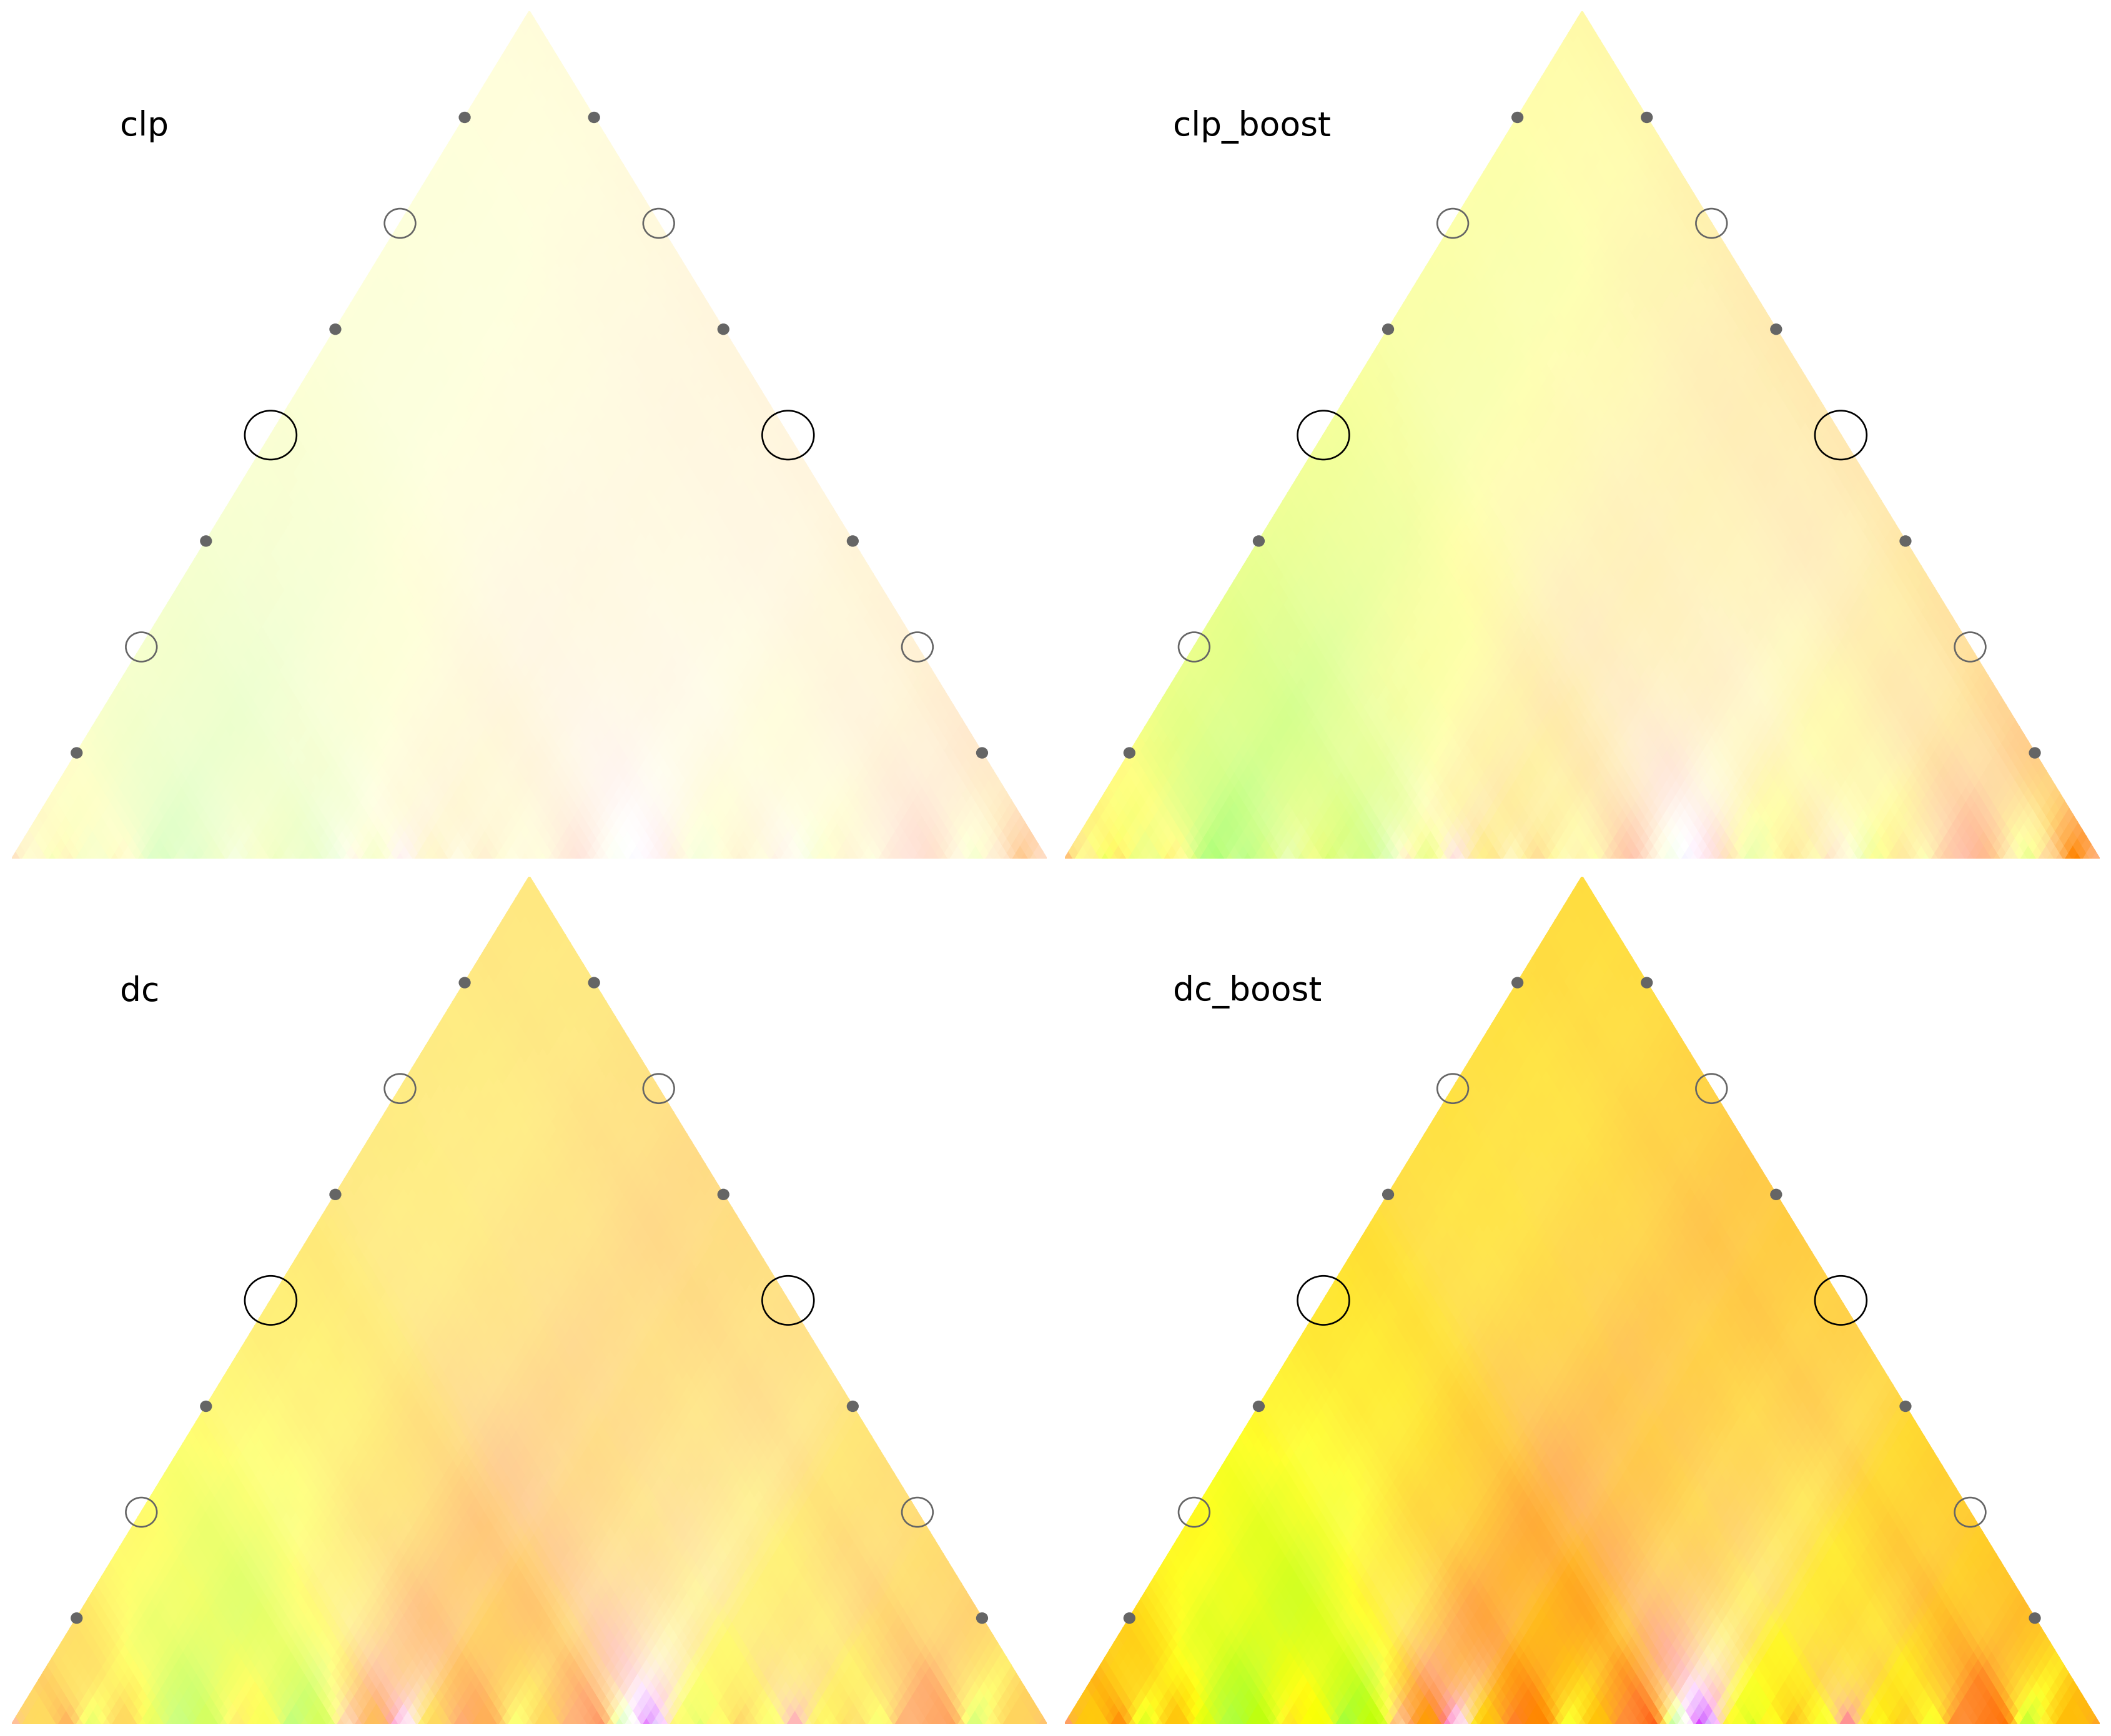

In [24]:
audio_file = bach_prelude_hc_audio
coefficient = 5

pc_mat_clp = produce_pitch_class_matrix_from_filename(audio_file, aw_size=1, deep_chroma=False)
pc_mat_dc = produce_pitch_class_matrix_from_filename(audio_file, aw_size=1, deep_chroma=True)
fourier_mat_clp = apply_dft_to_pitch_class_matrix(pc_mat_clp)
fourier_mat_dc = apply_dft_to_pitch_class_matrix(pc_mat_dc)
dpi = 96
total_width = 1700/dpi
total_height = 1400/dpi
indiv_w = 600
fig = plt.figure(figsize=(total_width, total_height), dpi=dpi)

clp_vanilla = complex_utm_to_ws_utm(fourier_mat_clp, coeff=coefficient, magn_stra='0c')
clp_boost = complex_utm_to_ws_utm(fourier_mat_clp, coeff=coefficient, magn_stra='boost')
dc_vanilla = complex_utm_to_ws_utm(fourier_mat_dc, coeff=coefficient, magn_stra='0c')
dc_boost = complex_utm_to_ws_utm(fourier_mat_dc, coeff=coefficient, magn_stra='boost')

ax = fig.add_subplot(2,2, 1)
Wavescape(clp_vanilla, pixel_width=indiv_w).draw(label='clp', ax=ax)

ax = fig.add_subplot(2,2, 2)
Wavescape(clp_boost, pixel_width=indiv_w).draw(label='clp_boost', ax=ax)

ax = fig.add_subplot(2,2, 3)
Wavescape(dc_vanilla, pixel_width=indiv_w).draw(label='dc', ax=ax)

ax = fig.add_subplot(2,2, 4)
Wavescape(dc_boost, pixel_width=indiv_w).draw(label='dc_boost', ax=ax)

plt.savefig('boosting_experiment2.png')

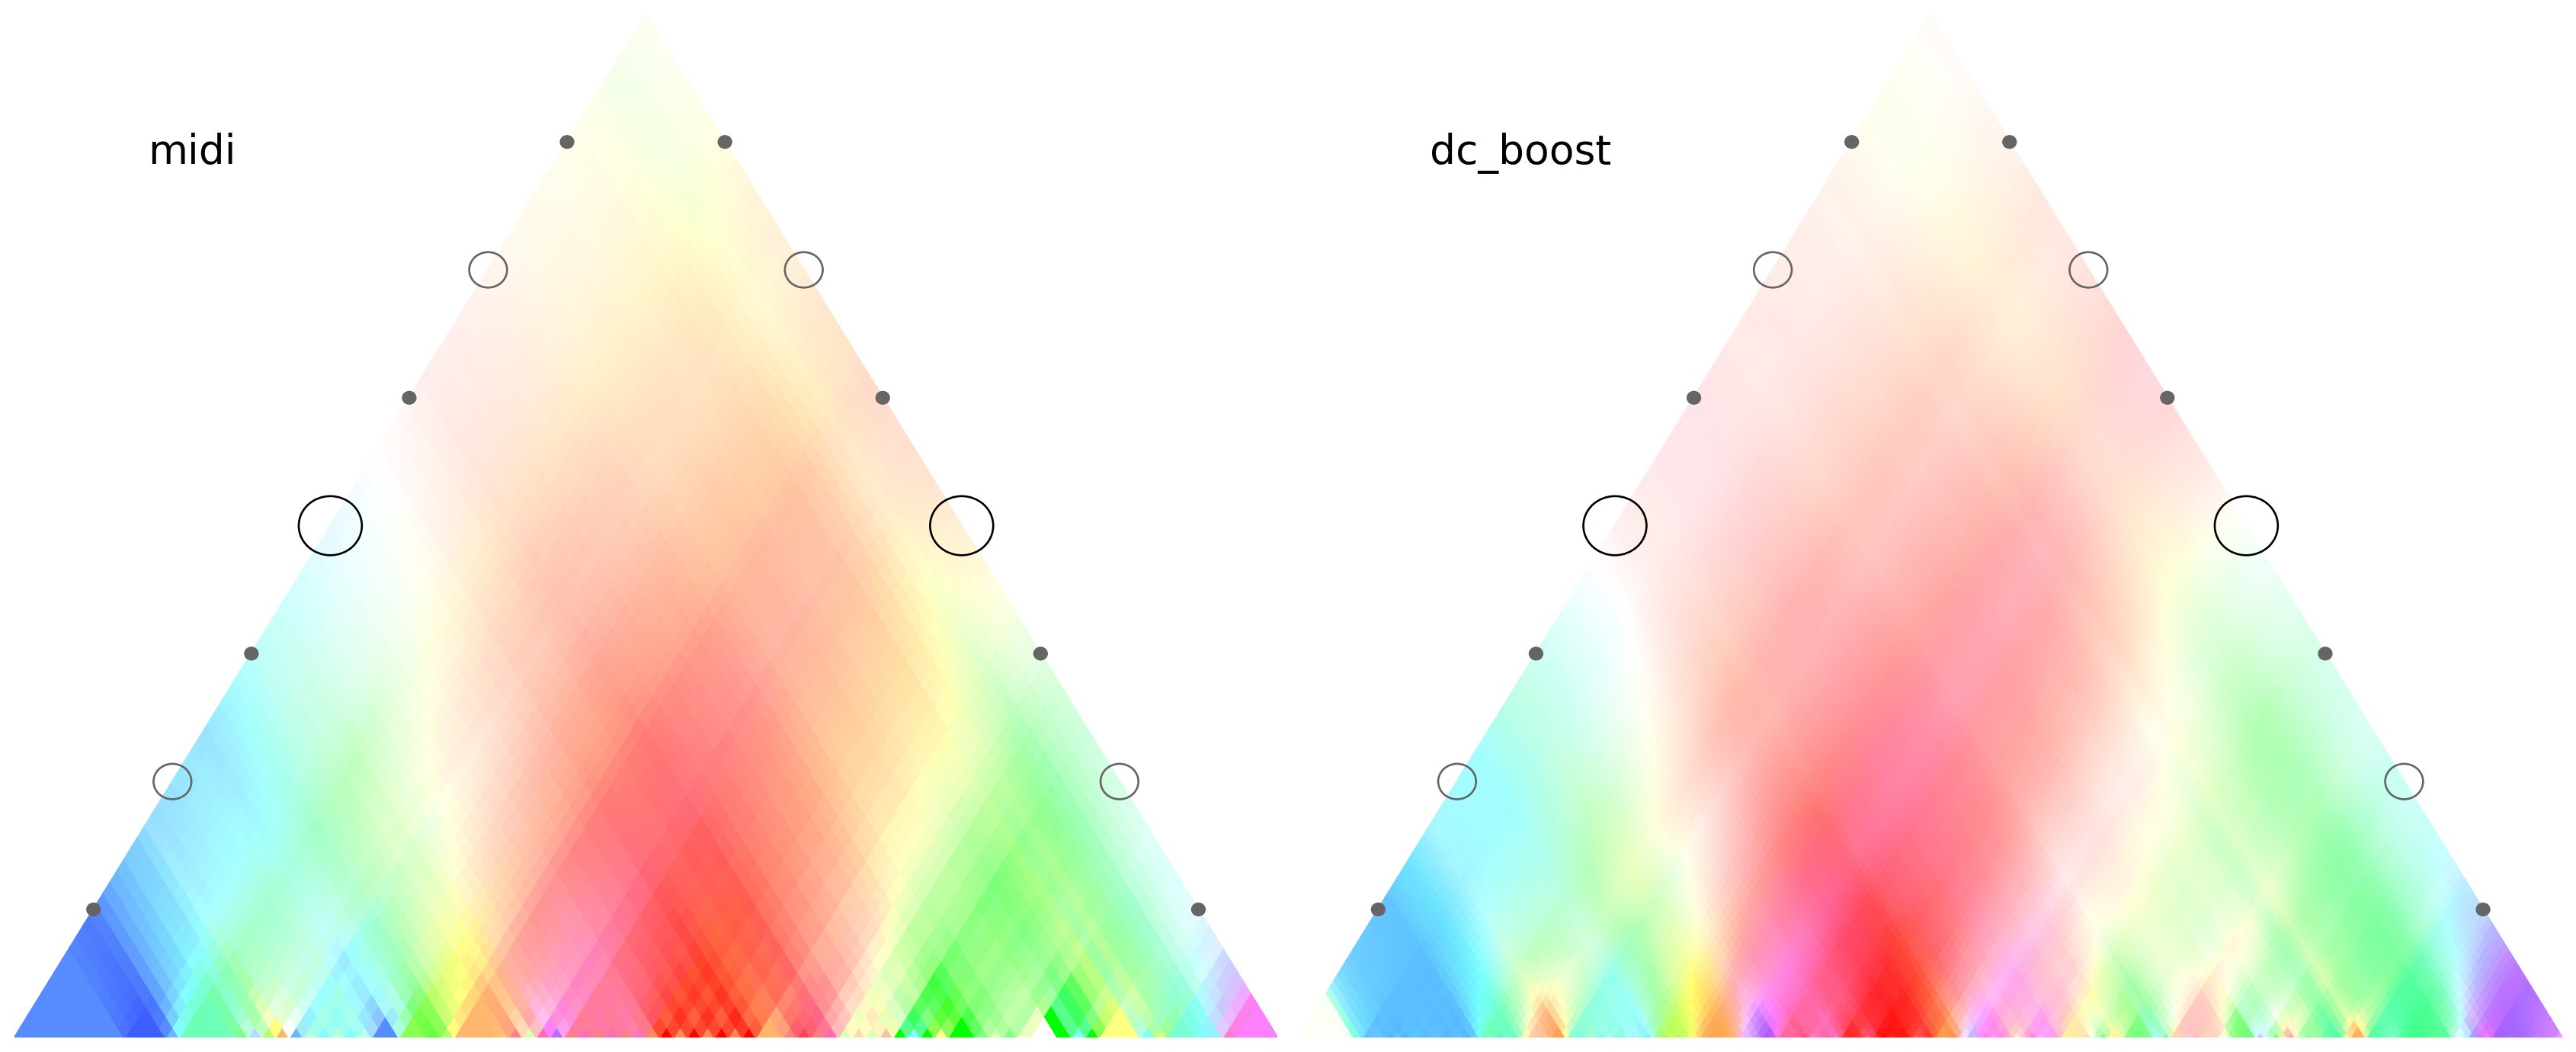

In [33]:
audio_file = chopin_audio
midi_file = chopin_midi
coefficient = 4

pc_mat_dc = produce_pitch_class_matrix_from_filename(audio_file, aw_size=1, deep_chroma=True)
fourier_mat_dc = apply_dft_to_pitch_class_matrix(pc_mat_dc)

pc_mat_midi = produce_pitch_class_matrix_from_filename(midi_file, aw_size=1)
fourier_mat_midi = apply_dft_to_pitch_class_matrix(pc_mat_midi)

dpi = 96
total_width = 1700/dpi
total_height = 700/dpi
indiv_w = 600

fig = plt.figure(figsize=(total_width, total_height), dpi=dpi)

dc_boost = complex_utm_to_ws_utm(fourier_mat_dc, coeff=coefficient, magn_stra='boost')

ax = fig.add_subplot(1,2, 1)
Wavescape(complex_utm_to_ws_utm(fourier_mat_midi, coeff=coefficient), pixel_width=indiv_w).draw(label='midi', ax=ax)

ax = fig.add_subplot(1,2, 2)
Wavescape(dc_boost, pixel_width=indiv_w).draw(label='dc_boost', ax=ax)

plt.savefig('boosting_experiment_vs_midi.png')

### Part 4.3 Legends' code

In [17]:
def legend_decomposition(pcv_dict, width = 13, single_img_coeff = None):
    '''
    Draw the circle color space defined by the color mapping used in wavescapes.
    Given a dict of labels/pitch-class vector, and list of coefficient to visualize,
    this function will plot the position of each of the PCV on the coefficient selected.
    This function helps visualising which color of the wavescape correspond to which musical 
    structure with respect to the coefficient number.
    
    Parameters
    ----------
    
    pcv_dict: dict, type of key is str, type of value is an array of array dimension (2,N) (0<= N, <=12)
        defines the label and pitch-class vector to be drawn, as well as the list of coefficients on which
        the pitch-class vector position needs to be drawn. For example, consider this dict is given to the
        function:
        {'CMaj':[[1,0,1,0,1,1,0,1,0,1,0,1], [5]],
         'Daug':[[0,0,1,0,0,0,1,0,0,0,1,0], [3,6]],
         'E': [0,0,0,0,1,0,0,0,0,0,0,0], [0]}
         The position of the C Major diatonic scale will be drawn on the color space of the fifth coefficient,
         while the position of the D augmented triad will be drawn on the color space of both the third and
         sixth coefficient. Finally, the value 0 associated to the single pitch PCV 'E' indicates its position
         will be drawn on all of the 6 coefficients. The label support LateX math mode.
    
    width: int, optional
        plot's width in inches.
        Default value is 13.
        
    single_img_coeff: int, optional
        Indicates which coefficient's color space will be drawn. If no number or "None" is provided for the value
        of this parameter, then the resulting plots will feature all 6 color space, one per coefficient. The coefficient
        number contain in the dict 'pcv_dict' still apply if a single coefficient is selected with this parameter.
        Default value is None.
        
    '''
    phivals = np.arange(0, 2*np.pi, 0.01)
    mu_step = .025
    muvals = np.arange(0, 1. + mu_step, mu_step)
    
    #powerset of all phis and mus.
    cartesian_polar = np.array(np.meshgrid(phivals, muvals)).T.reshape(-1, 2)
    
    #generating the color corresponding to each point.
    color_arr = []
    for phi, mu in cartesian_polar:
        hexa = rgb_to_hex(circular_hue(phi, magnitude=mu, opacity_mapping=True))
        color_arr.append(hexa)
        
    xvals = cartesian_polar[:,0]
    yvals = cartesian_polar[:,1]

    norm = mpl.colors.Normalize(0.0, 2*np.pi)
    fig = plt.figure(figsize= (width,width) if single_img_coeff else (width, 8*width/5) )
    
    def single_circle(ax, i, pcv_dict, marker_width, display_title=True):
        label_size = (marker_width/10.)
        ax.scatter(xvals, yvals, c=color_arr, s=marker_width, norm=norm, linewidths=1, marker='.')
        if display_title:
            ax.set_title(coeff_nbr_to_label(i)+' coefficient', fontdict={'fontsize': label_size+6}, y=1.08)
        for k,v in pcv_dict.items():
            for coeff in v[1]:
                if coeff == i or coeff == 0:
                    comp = np.fft.fft(v[0])
                    angle = np.angle(comp[i])
                    magn = np.abs(comp[i])/np.abs(comp[0])
                    ax.scatter(angle, magn, s=marker_width, facecolors='none', edgecolors='#777777')
                    pos_magn = np.abs(magn-0.125)
                    ax.annotate(k, (angle, pos_magn), size=(marker_width/10.)+2, annotation_clip=False, horizontalalignment='center', verticalalignment='center')
        
        ax.tick_params(axis='both', which='major', labelsize=(marker_width/10.)+6)
        ax.tick_params(axis='both', which='minor', labelsize=(marker_width/10.)+4)
        ax.set_xticklabels(['$0$', '', '$\pi/2$', '', '$\pi$', '', '$3\pi/2$', ''])
        ax.set_yticks([])
        ax.spines['polar'].set_visible(False)
        ax.xaxis.grid(False)
    
    if single_img_coeff:
        ax = plt.subplot(1, 1, 1, polar=True)
        single_circle(ax=ax, i=single_img_coeff, pcv_dict=pcv_dict, marker_width=20*width, display_title=False)
    else:
        for i in range(1, 7):
            ax = fig.add_subplot(3, 2, i, polar=True)
            single_circle(ax=ax, i=i, pcv_dict= pcv_dict, marker_width=10*width)
        plt.tight_layout() #needs to be before subplot_adjust, otherwise subplot_adjust is useless.
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)